In [1]:
from __future__ import division
import sys 
sys.path.insert(0,'../rl_network'); import actorcritic as ac
sys.path.insert(0,'../environments/'); import gridworld as eu
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline 
fig_savedir = '../data/figures/'
print_freq = 1/10

def save_value_map(vm, maze, trial):
    data = vm
    fig = plt.figure()
    im = plt.imshow(data, vmin = 0, vmax = 40, cmap='Spectral_r', interpolation ='none')
    rp_s = []
    for reward_loc in maze.rwd_loc:
        rp_s.append(eu.artist_instance(xy=np.add(reward_loc,(0,0)), rad = 0.2))
    im.cmap.set_bad('w', 1.0)
    for rp1 in rp_s:
        fig.axes[0].add_patch(rp1.art())
    plt.colorbar()
    plt.title('Trial {}'.format(trial))
    plt.savefig('../data/figures/trial_{}'.format(trial))
    plt.close()
    
def calc_convdims(network):
    print network.modules
    

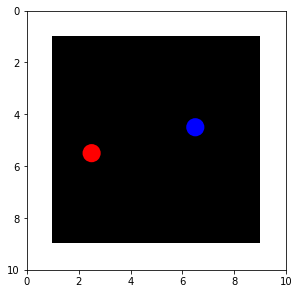

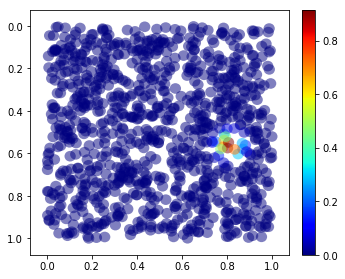

In [2]:
reload(eu)
# environment parameters 
y_height = 8
x_width = 8
walls = True
rho = 0
maze_type = 'none'
port_shift = 'none'

# place cell parameters
num_pc = 1000
fwhm = 0.05



#make environment
maze = eu.gridworld([y_height, x_width], 
                    rho = rho, 
                    maze_type = maze_type, 
                    port_shift = port_shift, 
                    walls = walls)
#maze.rwd_loc = [(int(y_new/2),int(x_new/2))]
#print maze.fwhm
for i in maze.rwd_loc: 
    maze.orig_rwd_loc.append(i)
pcs = eu.PlaceCells(num_cells=num_pc, grid=maze, fwhm=fwhm)

#show environment
eu.make_env_plots(maze,env=True,pc_map=True,pcs=pcs, save=False)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

state_type = 'conv'

In [3]:
if state_type == 'conv':
    if maze.bound:
        input_dims = (y_height+2,x_width+2,3)
    else: 
        input_dims = (y_height, x_width, 3)
    hid_types = ['conv', 'pool', 'linear']
    hid_dims = [(9,9,3), (6,6,3), 400]

elif state_type == 'pcs':
    input_dims = 1000
    hid_types = ['linear']
    hid_dims = [500]
    
action_dims = len(maze.actionlist)
batch_size = 1

NUM_EVENTS = 300
NUM_TRIALS = 1000



In [4]:
reload(ac)
MF = ac.AC_Net(input_dims, action_dims, batch_size, hid_types, hid_dims)
discount_factor = 0.98

eta = 5e-4 #gradient descent learning rate
opt = ac.optim.Adam(MF.parameters(), lr = eta)

In [5]:
total_loss = [[],[]]
total_reward = []
val_maps = []

blocktime = time.time()
for trial in xrange(NUM_TRIALS):
    reward_sum = 0
    if state_type == 'pcs':
        get_pcs = pcs.activity(env.reset())
        state = ac.Variable(ac.torch.FloatTensor(get_pcs))
    elif state_type == 'conv':
        env.reset()
        # because we need to include batch size of 1 
        frame = np.expand_dims(eu.get_frame(maze), axis=0)
        state = ac.Variable(ac.torch.FloatTensor(frame))
        
    MF.reinit_hid()
    for event in xrange(NUM_EVENTS):
        policy_, value_ = MF(state)
        choice, policy, value = ac.select_action_end(MF,policy_, value_)
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)

        MF.rewards.append(reward)
        if state_type == 'pcs':
            state = ac.Variable(ac.torch.FloatTensor(pcs.activity(next_state)))       # update state
        elif state_type == 'conv':
            print maze.cur_state, "##"
            # because we need to include batch size of 1 
            frame = np.expand_dims(eu.get_frame(maze), axis = 0)
            state = ac.Variable(ac.torch.FloatTensor(frame))
        reward_sum += reward

    p_loss, v_loss = ac.finish_trial(MF, discount_factor,opt)
    
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)
    
    value_map = ac.generate_values(maze,MF,pcs)
    val_maps.append(value_map.copy())
    
    #if trial%10 == 0:
    #    save_value_map(value_map.copy(), maze, trial)
    
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 

torch.Size([1, 3, 10, 10]) <type 'tuple'>


RuntimeError: size mismatch, m1: [1 x 192], m2: [108 x 400] at /pytorch/torch/lib/TH/generic/THTensorMath.c:1416

In [ ]:
plt.plot(total_loss[0], label='p')
plt.plot(total_loss[1], label='v')
plt.show()

plt.plot(total_reward, label='r', color='r')

In [ ]:
eu.print_value_maps(maze,val_maps,maps=698,save_dir=fig_savedir,title='Value Map') ### see individual map with kwarg maps=X